## Optimize the Model

### First Exploration: Increase the Number of Epochs from 100 to 200

In [27]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
import os
from tensorflow.keras.callbacks import ModelCheckpoint

#  Import and read the charity_data.csv.
import pandas as pd 
application_df = pd.read_csv("Resources/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [2]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(labels=["EIN", "NAME"], axis=1)

In [6]:
# Determine which values to replace if counts are less than 500
replace_application = list(type_valuecount[type_valuecount < 500].index)

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

In [9]:
# Determine which values to replace if counts are less than 1000
replace_class = list(classification_valuecounts[classification_valuecounts < 1800].index)

# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
    
# Check to make sure binning was successful
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

In [10]:
# Generate our categorical variable lists
application_cat = list(application_df.dtypes[application_df.dtypes == "object"].index)
application_cat

['APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT',
 'SPECIAL_CONSIDERATIONS']

In [11]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(application_cat)
encode_df.head()

C:\Users\leece\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [12]:
# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df, left_index=True, right_index=True)
application_df = application_df.drop(labels=application_cat, axis=1)
application_df.head()

,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,108590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,5000,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,6692,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,142590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [13]:
# Split our preprocessed data into our features and target arrays
y = application_df["IS_SUCCESSFUL"].values.reshape(-1, 1)
X = application_df.drop("IS_SUCCESSFUL", axis=1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [14]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [15]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])

# number of layer1 neurons = 2*(number of inputs=43) = 86 ~ 80
hidden_nodes_layer1 = 80

# number of layer2 neurons: Between (input=80) and (output=1 - classifier)
hidden_nodes_layer2 = 30

# instantiate the model
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))  # binary clasifier -> 1 output neuron/sigmoid activation

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                3520      
                                                                 
 dense_1 (Dense)             (None, 30)                2430      
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 5,981
Trainable params: 5,981
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [17]:
# Add model weight checkpoints during training
os.makedirs("checkpoints/", exist_ok=True)
checkpoint_path="checkpoints/weights.{epoch}.hdf5"

# Create callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              verbose=1,
                              save_weights_only=True,
                              save_freq="epoch",
                              period=5)

In [18]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=200, callbacks=[cp_callback])

Epoch 1/200
804/804 [==============================] - 4s 3ms/step - loss: 0.5717 - accuracy: 0.7190
Epoch 2/200
804/804 [==============================] - 3s 3ms/step - loss: 0.5579 - accuracy: 0.7275
Epoch 3/200
804/804 [==============================] - 3s 3ms/step - loss: 0.5547 - accuracy: 0.7276
Epoch 4/200
804/804 [==============================] - 3s 3ms/step - loss: 0.5533 - accuracy: 0.7285
Epoch 5/200
789/804 [============================>.] - ETA: 0s - loss: 0.5511 - accuracy: 0.7288
Epoch 5: saving model to checkpoints\weights.5.hdf5
804/804 [==============================] - 3s 3ms/step - loss: 0.5520 - accuracy: 0.7280
Epoch 6/200
804/804 [==============================] - 3s 3ms/step - loss: 0.5514 - accuracy: 0.7292
Epoch 7/200
804/804 [==============================] - 3s 3ms/step - loss: 0.5504 - accuracy: 0.7291
Epoch 8/200
804/804 [==============================] - 3s 3ms/step - loss: 0.5493 - accuracy: 0.7309
Epoch 9/200
804/804 [==============================] - 

800/804 [============================>.] - ETA: 0s - loss: 0.5385 - accuracy: 0.7361
Epoch 65: saving model to checkpoints\weights.65.hdf5
804/804 [==============================] - 3s 3ms/step - loss: 0.5386 - accuracy: 0.7362
Epoch 66/200
804/804 [==============================] - 3s 3ms/step - loss: 0.5392 - accuracy: 0.7366
Epoch 67/200
804/804 [==============================] - 3s 3ms/step - loss: 0.5388 - accuracy: 0.7372
Epoch 68/200
804/804 [==============================] - 3s 3ms/step - loss: 0.5389 - accuracy: 0.7362
Epoch 69/200
804/804 [==============================] - 3s 3ms/step - loss: 0.5388 - accuracy: 0.7365
Epoch 70/200
792/804 [============================>.] - ETA: 0s - loss: 0.5386 - accuracy: 0.7367
Epoch 70: saving model to checkpoints\weights.70.hdf5
804/804 [==============================] - 3s 3ms/step - loss: 0.5386 - accuracy: 0.7365
Epoch 71/200
804/804 [==============================] - 3s 3ms/step - loss: 0.5386 - accuracy: 0.7366
Epoch 72/200
804/804 

789/804 [============================>.] - ETA: 0s - loss: 0.5352 - accuracy: 0.7383
Epoch 190: saving model to checkpoints\weights.190.hdf5
804/804 [==============================] - 3s 3ms/step - loss: 0.5347 - accuracy: 0.7386
Epoch 191/200
804/804 [==============================] - 2s 3ms/step - loss: 0.5339 - accuracy: 0.7378
Epoch 192/200
804/804 [==============================] - 7s 8ms/step - loss: 0.5342 - accuracy: 0.7377
Epoch 193/200
804/804 [==============================] - 1s 991us/step - loss: 0.5342 - accuracy: 0.7371
Epoch 194/200
804/804 [==============================] - 1s 837us/step - loss: 0.5344 - accuracy: 0.7382
Epoch 195/200
791/804 [============================>.] - ETA: 0s - loss: 0.5353 - accuracy: 0.7386
Epoch 195: saving model to checkpoints\weights.195.hdf5
804/804 [==============================] - 1s 846us/step - loss: 0.5352 - accuracy: 0.7386
Epoch 196/200
804/804 [==============================] - 1s 812us/step - loss: 0.5344 - accuracy: 0.7381
Epo

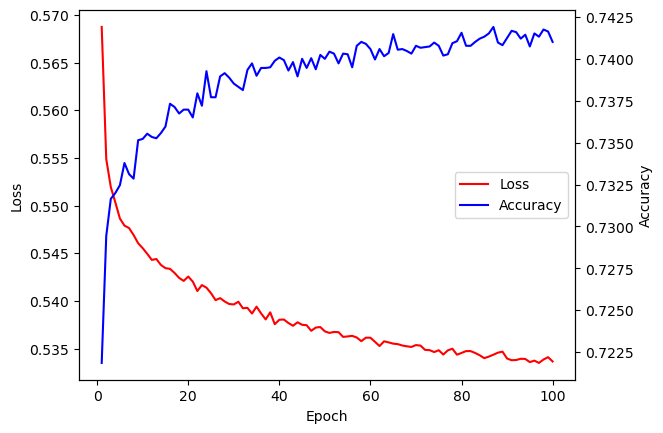

In [47]:
# Visualize Loss/Accuracy
import matplotlib.pyplot as plt
history_df = pd.DataFrame(fit_model.history,
                          index=range(1, len(fit_model.history["loss"]) + 1))

fig, ax = plt.subplots()
loss = ax.plot(history_df["loss"], color="red", label="Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

ax2 = ax.twinx()
acc = ax2.plot(history_df["accuracy"], color="blue", label="Accuracy")
ax2.set_ylabel("Accuracy")

curves = loss + acc
labs = [l.get_label() for l in curves]
ax.legend(curves, labs, loc="center right")

plt.show()

In [19]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - loss: 0.5637 - accuracy: 0.7370 - 940ms/epoch - 4ms/step
Loss: 0.5636997818946838, Accuracy: 0.7370262145996094


#### Increasing the epochs to 200 caused the accuracy to decrease slightly

### Second Exploration: Sigmoid Activation Function Instead of ReLU

In [26]:
# Instantiate the model
nn_sigmoid = tf.keras.models.Sequential()

# First hidden layer - changing activation function to sigmoid
nn_sigmoid.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="sigmoid"))

# Second hidden layer
nn_sigmoid.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="sigmoid"))

# Output layer
nn_sigmoid.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn_sigmoid.summary()
Model: "sequential_1"

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 80)                3520      
                                                                 
 dense_10 (Dense)            (None, 30)                2430      
                                                                 
 dense_11 (Dense)            (None, 1)                 31        
                                                                 
Total params: 5,981
Trainable params: 5,981
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Compile the model
nn_sigmoid.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [23]:
# Fit the model
fit_model_sigmoid = nn_sigmoid.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
804/804 [==============================] - 1s 951us/step - loss: 0.5953 - accuracy: 0.7006
Epoch 2/100
804/804 [==============================] - 1s 970us/step - loss: 0.5756 - accuracy: 0.7198
Epoch 3/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5716 - accuracy: 0.7209
Epoch 4/100
804/804 [==============================] - 1s 932us/step - loss: 0.5669 - accuracy: 0.7232
Epoch 5/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5626 - accuracy: 0.7259
Epoch 6/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5597 - accuracy: 0.7257
Epoch 7/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5573 - accuracy: 0.7270
Epoch 8/100
804/804 [==============================] - 1s 924us/step - loss: 0.5563 - accuracy: 0.7272
Epoch 9/100
804/804 [==============================] - 1s 916us/step - loss: 0.5552 - accuracy: 0.7273
Epoch 10/100
804/804 [==============================] - 1s 903us/step - loss: 0.5

804/804 [==============================] - 1s 905us/step - loss: 0.5386 - accuracy: 0.7357
Epoch 81/100
804/804 [==============================] - 1s 891us/step - loss: 0.5384 - accuracy: 0.7353
Epoch 82/100
804/804 [==============================] - 1s 899us/step - loss: 0.5388 - accuracy: 0.7362
Epoch 83/100
804/804 [==============================] - 1s 907us/step - loss: 0.5384 - accuracy: 0.7360
Epoch 84/100
804/804 [==============================] - 1s 922us/step - loss: 0.5382 - accuracy: 0.7367
Epoch 85/100
804/804 [==============================] - 1s 927us/step - loss: 0.5383 - accuracy: 0.7363
Epoch 86/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5384 - accuracy: 0.7360
Epoch 87/100
804/804 [==============================] - 1s 998us/step - loss: 0.5378 - accuracy: 0.7355
Epoch 88/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5380 - accuracy: 0.7361
Epoch 89/100
804/804 [==============================] - 1s 1ms/step - loss: 0.537

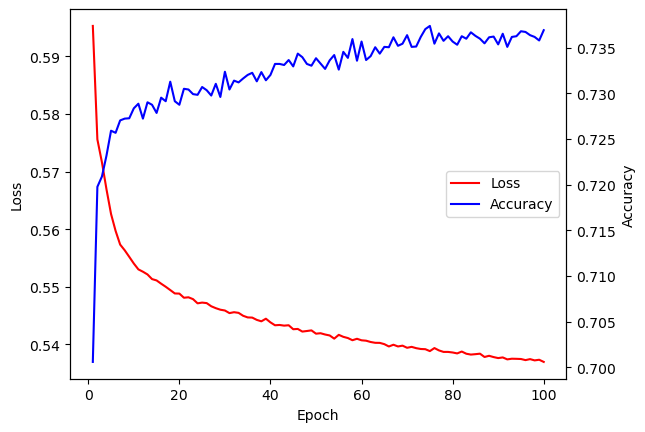

In [24]:
# Visualize Loss/Accuracy
import matplotlib.pyplot as plt
history_df = pd.DataFrame(fit_model_sigmoid.history,
                          index=range(1, len(fit_model_sigmoid.history["loss"]) + 1))

fig, ax = plt.subplots()
loss = ax.plot(history_df["loss"], color="red", label="Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

ax2 = ax.twinx()
acc = ax2.plot(history_df["accuracy"], color="blue", label="Accuracy")
ax2.set_ylabel("Accuracy")

curves = loss + acc
labs = [l.get_label() for l in curves]
ax.legend(curves, labs, loc="center right")

plt.show()

In [25]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_sigmoid.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5497 - accuracy: 0.7333 - 279ms/epoch - 1ms/step
Loss: 0.5497457981109619, Accuracy: 0.7332944869995117


#### Changing the activation function to sigmoid results in a slightly lower accuracy

### Third Exploration: Increasing the Number of Hidden Layers

In [33]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])

# number of layer1 neurons = 2*(number of inputs=43) = 86 ~ 80
hidden_nodes_layer1 = 80

# number of layer2 neurons: Between (input=80) and (output=1 - classifier)
hidden_nodes_layer2 = 30

# number of layer3 neurons: Between (input=80) and (output=1 - classifier)
hidden_nodes_layer3 = 30

# number of layer4 neurons: Between (input=80) and (output=1 - classifier)
hidden_nodes_layer4 = 30

# instantiate the model
nn_morelayers = tf.keras.models.Sequential()

# First hidden layer
nn_morelayers.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn_morelayers.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn_morelayers.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Fourth hidden layer
nn_morelayers.add(tf.keras.layers.Dense(units=hidden_nodes_layer4, activation="relu"))

# Output layer
nn_morelayers.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))  # binary clasifier -> 1 output neuron/sigmoid activation

# Check the structure of the model
nn_morelayers.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 80)                3520      
                                                                 
 dense_18 (Dense)            (None, 30)                2430      
                                                                 
 dense_19 (Dense)            (None, 30)                930       
                                                                 
 dense_20 (Dense)            (None, 30)                930       
                                                                 
 dense_21 (Dense)            (None, 1)                 31        
                                                                 
Total params: 7,841
Trainable params: 7,841
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Compile the model
nn_morelayers.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [35]:
# Fit the model
fit_model_morelayers = nn_morelayers.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
804/804 [==============================] - 2s 1ms/step - loss: 0.5731 - accuracy: 0.7174
Epoch 2/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5569 - accuracy: 0.7262
Epoch 3/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5535 - accuracy: 0.7277
Epoch 4/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5523 - accuracy: 0.7283
Epoch 5/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5511 - accuracy: 0.7295
Epoch 6/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5507 - accuracy: 0.7298
Epoch 7/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5493 - accuracy: 0.7306
Epoch 8/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5483 - accuracy: 0.7310
Epoch 9/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5483 - accuracy: 0.7309
Epoch 10/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5478 - accura

804/804 [==============================] - 1s 1ms/step - loss: 0.5357 - accuracy: 0.7372
Epoch 82/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5360 - accuracy: 0.7372
Epoch 83/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5358 - accuracy: 0.7369
Epoch 84/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5358 - accuracy: 0.7371
Epoch 85/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5357 - accuracy: 0.7375
Epoch 86/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5358 - accuracy: 0.7372
Epoch 87/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5354 - accuracy: 0.7371
Epoch 88/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5359 - accuracy: 0.7373
Epoch 89/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5359 - accuracy: 0.7378
Epoch 90/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5357 - accuracy: 

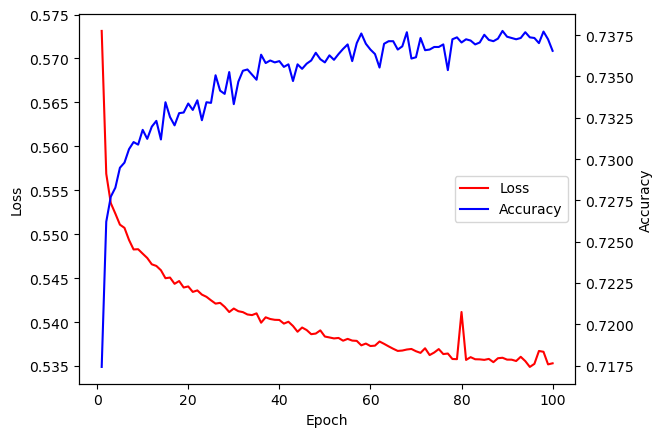

In [36]:
# Visualize Loss/Accuracy
import matplotlib.pyplot as plt
history_df = pd.DataFrame(fit_model_morelayers.history,
                          index=range(1, len(fit_model_morelayers.history["loss"]) + 1))

fig, ax = plt.subplots()
loss = ax.plot(history_df["loss"], color="red", label="Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

ax2 = ax.twinx()
acc = ax2.plot(history_df["accuracy"], color="blue", label="Accuracy")
ax2.set_ylabel("Accuracy")

curves = loss + acc
labs = [l.get_label() for l in curves]
ax.legend(curves, labs, loc="center right")

plt.show()

In [37]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_morelayers.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5669 - accuracy: 0.7359 - 388ms/epoch - 1ms/step
Loss: 0.5668830871582031, Accuracy: 0.7358600497245789


#### Accuracy is slightly improved!

### Fourth Exploration: Adjusting Input Data by Dropping or Binning Noisy Features

In [40]:
# Read in data before initial processing
application_df = pd.read_csv("Resources/charity_data.csv")
application_df

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1
...,...,...,...,...,...,...,...,...,...,...,...,...
34294,996009318,THE LIONS CLUB OF HONOLULU KAMEHAMEHA,T4,Independent,C1000,ProductDev,Association,1,0,N,5000,0
34295,996010315,INTERNATIONAL ASSOCIATION OF LIONS CLUBS,T4,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
34296,996012607,PTA HAWAII CONGRESS,T3,CompanySponsored,C2000,Preservation,Association,1,0,N,5000,0
34297,996015768,AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES LO...,T5,Independent,C3000,ProductDev,Association,1,0,N,5000,1


In [43]:
# Bucket predetermined features and drop unneccesary columns
# Drop 'EIN' and 'NAME' columns
application_df = application_df.drop(labels=["EIN", "NAME"], axis=1)

# Determine which values to replace if counts are less than 500
replace_application = list(type_valuecount[type_valuecount < 500].index)

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")

# Replace in dataframe
for app in replace_application:
    application_df["APPLICATION_TYPE"] = application_df["APPLICATION_TYPE"].replace(app, "Other")

# Determine which values to replace if counts are less than 1000
replace_class = list(classification_valuecounts[classification_valuecounts < 1800].index)

# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")

In [44]:
# Check dataframe 
application_df

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1
...,...,...,...,...,...,...,...,...,...,...
34294,T4,Independent,C1000,ProductDev,Association,1,0,N,5000,0
34295,T4,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
34296,T3,CompanySponsored,C2000,Preservation,Association,1,0,N,5000,0
34297,T5,Independent,C3000,ProductDev,Association,1,0,N,5000,1


In [46]:
# Look at AFFILIATION value counts for binning
type_affiliation = application_df['AFFILIATION'].value_counts()
type_affiliation

Independent         18480
CompanySponsored    15705
Family/Parent          64
National               33
Regional               13
Other                   4
Name: AFFILIATION, dtype: int64

In [50]:
# Bin the small categories into one 'other' category
# Determine which values to replace if counts are less than 500
replace_affiliation = list(type_affiliation[type_affiliation < 500].index)

# Replace in dataframe
for app in replace_affiliation:
    application_df.AFFILIATION = application_df.AFFILIATION.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.AFFILIATION.value_counts()

Independent         18480
CompanySponsored    15705
Other                 114
Name: AFFILIATION, dtype: int64

In [52]:
# Look at USE_CASE value counts for binning
type_usecase = application_df['USE_CASE'].value_counts()
type_usecase # few categories and other is already created

Preservation     28095
ProductDev        5671
CommunityServ      384
Heathcare          146
Other                3
Name: USE_CASE, dtype: int64

In [53]:
# Look at ORGANIZATION value counts for binning
type_organization = application_df['ORGANIZATION'].value_counts()
type_organization # few categories

Trust           23515
Association     10255
Co-operative      486
Corporation        43
Name: ORGANIZATION, dtype: int64

In [54]:
# Look at INCOME_AMT value counts for binning
type_income = application_df['INCOME_AMT'].value_counts()
type_income

0                24388
25000-99999       3747
100000-499999     3374
1M-5M              955
1-9999             728
10000-24999        543
10M-50M            240
5M-10M             185
50M+               139
Name: INCOME_AMT, dtype: int64

In [57]:
# Bin the small categories into one 'other' category
# Determine which values to replace if counts are less than 500
replace_income = list(type_income[type_income < 1000].index)

# Replace in dataframe
for app in replace_income:
    application_df.INCOME_AMT = application_df.INCOME_AMT.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.INCOME_AMT.value_counts()

0                24388
25000-99999       3747
100000-499999     3374
Other             2790
Name: INCOME_AMT, dtype: int64

In [58]:
# Look at SPECIAL_CONSIDERATIONS value counts for binning
type_considerations = application_df['SPECIAL_CONSIDERATIONS'].value_counts()
type_considerations # few categories

N    34272
Y       27
Name: SPECIAL_CONSIDERATIONS, dtype: int64

In [59]:
# Look at ASK_AMT value counts for binning
type_ask = application_df['ASK_AMT'].value_counts()
type_ask # categories have unique values

5000        25398
10478           3
15583           3
63981           3
6725            3
            ...  
5371754         1
30060           1
43091152        1
18683           1
36500179        1
Name: ASK_AMT, Length: 8747, dtype: int64

In [62]:
# Generate our categorical variable lists
application_cat = list(application_df.dtypes[application_df.dtypes == "object"].index)
application_cat

['APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT',
 'SPECIAL_CONSIDERATIONS']

In [63]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(application_cat)
encode_df.head()

C:\Users\leece\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,...,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_100000-499999,INCOME_AMT_25000-99999,INCOME_AMT_Other,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [64]:
# Drop SPECIAL_CONSIDERATIONS_Y because it is redundant
encode_df = encode_df.drop(labels=["SPECIAL_CONSIDERATIONS_Y"], axis=1)

In [65]:
# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df, left_index=True, right_index=True)
application_df = application_df.drop(labels=application_cat, axis=1)
application_df.head()

,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,...,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_100000-499999,INCOME_AMT_25000-99999,INCOME_AMT_Other,SPECIAL_CONSIDERATIONS_N
0,1,5000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1,108590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,1,5000,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1,6692,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
4,1,142590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [66]:
# Split our preprocessed data into our features and target arrays
y = application_df["IS_SUCCESSFUL"].values.reshape(-1, 1)
X = application_df.drop("IS_SUCCESSFUL", axis=1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [72]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])

# number of layer1 neurons = 2*(number of inputs=43) = 86 ~ 80
hidden_nodes_layer1 = 80

# number of layer2 neurons: Between (input=80) and (output=1 - classifier)
hidden_nodes_layer2 = 30

# instantiate the model
nn_morebinning = tf.keras.models.Sequential()

# First hidden layer
nn_morebinning.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn_morebinning.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn_morebinning.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))  # binary clasifier -> 1 output neuron/sigmoid activation

# Check the structure of the model
nn_morebinning.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 80)                2800      
                                                                 
 dense_26 (Dense)            (None, 30)                2430      
                                                                 
 dense_27 (Dense)            (None, 1)                 31        
                                                                 
Total params: 5,261
Trainable params: 5,261
Non-trainable params: 0
_________________________________________________________________


In [74]:
# Compile the model
nn_morebinning.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [75]:
# Add model weight checkpoints
os.makedirs("checkpoints/", exist_ok=True)
checkpoint_path="checkpoints/weights.{epoch}.hdf5"

# Create callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              verbose=1,
                              save_weights_only=True,
                              save_freq="epoch",
                              period=5)

In [76]:
# Train the model
fit_model = nn_morebinning.fit(X_train_scaled, y_train, epochs=100, callbacks=[cp_callback])

Epoch 1/100
804/804 [==============================] - 1s 965us/step - loss: 0.5685 - accuracy: 0.7227
Epoch 2/100
804/804 [==============================] - 1s 990us/step - loss: 0.5563 - accuracy: 0.7292
Epoch 3/100
804/804 [==============================] - 1s 988us/step - loss: 0.5530 - accuracy: 0.7289
Epoch 4/100
804/804 [==============================] - 1s 981us/step - loss: 0.5523 - accuracy: 0.7306
Epoch 5/100
760/804 [===========================>..] - ETA: 0s - loss: 0.5496 - accuracy: 0.7331
Epoch 5: saving model to checkpoints\weights.5.hdf5
804/804 [==============================] - 1s 1ms/step - loss: 0.5513 - accuracy: 0.7313
Epoch 6/100
804/804 [==============================] - 1s 949us/step - loss: 0.5496 - accuracy: 0.7306
Epoch 7/100
804/804 [==============================] - 1s 924us/step - loss: 0.5497 - accuracy: 0.7324
Epoch 8/100
804/804 [==============================] - 1s 992us/step - loss: 0.5485 - accuracy: 0.7328
Epoch 9/100
804/804 [====================

804/804 [==============================] - 1s 1ms/step - loss: 0.5385 - accuracy: 0.7385
Epoch 65/100
794/804 [============================>.] - ETA: 0s - loss: 0.5391 - accuracy: 0.7374
Epoch 65: saving model to checkpoints\weights.65.hdf5
804/804 [==============================] - 1s 1ms/step - loss: 0.5387 - accuracy: 0.7378
Epoch 66/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5391 - accuracy: 0.7375
Epoch 67/100
804/804 [==============================] - 1s 988us/step - loss: 0.5385 - accuracy: 0.7383
Epoch 68/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5386 - accuracy: 0.7372
Epoch 69/100
804/804 [==============================] - 1s 999us/step - loss: 0.5383 - accuracy: 0.7374
Epoch 70/100
800/804 [============================>.] - ETA: 0s - loss: 0.5382 - accuracy: 0.7371
Epoch 70: saving model to checkpoints\weights.70.hdf5
804/804 [==============================] - 1s 1ms/step - loss: 0.5383 - accuracy: 0.7371
Epoch 71/100
804/

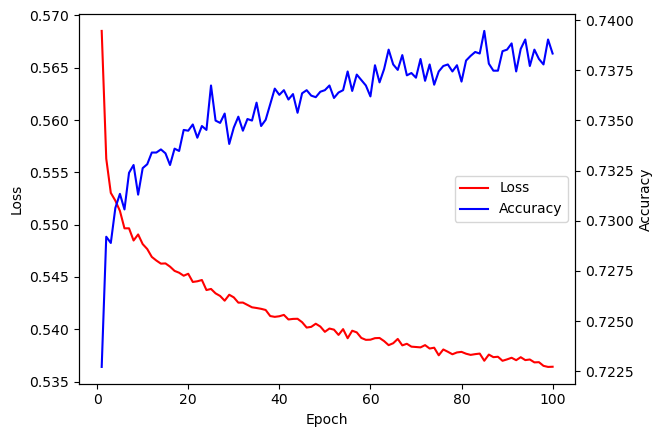

In [77]:
# Visualize the losses and accuracy
history_df = pd.DataFrame(fit_model.history,
                          index=range(1, len(fit_model.history["loss"]) + 1))

fig, ax = plt.subplots()
loss = ax.plot(history_df["loss"], color="red", label="Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

ax2 = ax.twinx()
acc = ax2.plot(history_df["accuracy"], color="blue", label="Accuracy")
ax2.set_ylabel("Accuracy")

curves = loss + acc
labs = [l.get_label() for l in curves]
ax.legend(curves, labs, loc="center right")

plt.show()

In [78]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_morebinning.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5664 - accuracy: 0.7266 - 260ms/epoch - 970us/step
Loss: 0.5663846731185913, Accuracy: 0.7266472578048706


#### Model accuracy decreases slightly after increased binning and dropping of features

In [79]:
# Export and save model to HDF5 file
nn.save("AlphabetSoupCharity_Optimization.h5")